[En français](../use-case_arthur_fr/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > WMS request in Python

# Use case: anticipated profits based on precipitations probability

## Introduction

Weather, climate and water data from [MSC GeoMet](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/) geospatial web services can be easily used to predict demand associated with certain products or services. This usage example show how to extract and process raw meteorological data with [Python](https://www.python.org/) programming language to create a tool to calculate anticipated profits from sales depending on meteorological conditions. This use case teaches you how to:
* Access and query meteorological data from MSC GeoMet geospatial web services;
* Query layers to get data for specific locations;
* Create temporal queries;
* Show results in different formats including plots and data tables.

The [interactive version of this Jupyter Notebook is available](https://mybinder.org/v2/gh/ECCC-MSC/open-data/master?filepath=docs%2Fusage%2Fuse-case_arthur%2Fuse-case_arthur_en.ipynb).

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=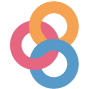)](https://mybinder.org/v2/gh/ECCC-MSC/open-data/master?filepath=docs%2Fusage%2Fuse-case_arthur%2Fuse-case_arthur_en.ipynb)

## Creation of a tool to calculate anticipated profits

Consider the following situation: Arthur, a souvenir kiosk owner in Vancouver, wants to calculate the profits he anticipates making from umbrellas sales using Environment and Climate Change Canada weather forecast. Indeed, his umbrellas sales increase drastically when there is at least 30% chance that there will be a minimum of 5 mm of precipitations. Considering that the kiosk is open from 9 a.m. to 9 p.m, Arthur wants to calculate how much profits he anticipates to make in the following days according to the weather forecast obtained from MSC GeoMet geospatial web services.

To determinate the amount of umbrellas that is predicted to be sold in the next days, the first step is to query the [Web Map Service (WMS)](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#web-map-service-wms) from MSC to get the probability of getting 5 mm or more of precipitations for the time, the date and the location desired through Python programming. To carry out this step, the Python modules must first be imported and values must be given to the request parameters including the layer name, the coordinates of the location and the local time zone. The layer used for this exemple will be the layer from the [Regional Ensemble Prediction System (REPS)](https://eccc-msc.github.io/open-data/msc-data/nwp_reps/readme_reps_en/) that contains the probability that the quantity of precipitations will be equal or greater than 5 mm (``REPS.DIAG.3_PRMM.ERGE5``).

In [1]:
# Importation of Python modules 
from datetime import datetime, timedelta
import re
import warnings

# The following modules must first be installed to use 
# this code out of Jupyter Notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy
from owslib.wms import WebMapService
import pandas
from tabulate import tabulate

# Ignore warnings from the OWSLib module
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

# Parameters choice
# Layer:
layer = 'REPS.DIAG.3_PRMM.ERGE5'
# Coordinates:
y, x = 49.288, -123.116
# Local time zone (in this exemple, the local time zone is UTC-07:00):
time_zone = -7

Once the parameters are chosen, the request's ``bbox`` parameter values (location aimed by the query) have to be calculated.

In [2]:
# bbox parameter
min_x, min_y, max_x, max_y = x - 0.25, y - 0.25, x + 0.25, y + 0.25

To access the layer metadata, the connection to the WMS service has to be established.

In [3]:
# WMS service connection
wms = WebMapService('https://geo.weather.gc.ca/geomet?SERVICE=WMS' +
                    '&REQUEST=GetCapabilities',
                    version='1.3.0',
                    timeout=300)

The starting and ending time of the available predictions and the time interval between available predictions can be recovered with a ``GetCapabilities`` request. In this request, ``dimensions`` refers to the homonymous section in the layer's metadata that contains temporal information. As ``dimensions`` is a Python dictionary, it is possible to recover the necessary information using dictionary keys and the ``split`` method to split character chains around the slash symbol. For the time interval, the numbers can be recovered with the ``re.sub`` method that replace all the characters that are not numerical with empty space.

Then, the time and date of all available predictions from the starting time to the ending time for the UTC±00:00 time zone can be obtained with a ``while`` loop. Theses informations are necessary to carry out the WMS request. The same ``while`` loop will be used to get the local time and date of all the predictions. The local time and date will be used in the plots and data tables in order to facilitate the result interpretation. 

In [4]:
# Extraction of temporal information from metadata
def time_parameters(layer):
    start_time, end_time, interval = (wms[layer]
                                      .dimensions['time']['values'][0]
                                      .split('/')
                                      )
    iso_format = '%Y-%m-%dT%H:%M:%SZ'
    start_time = datetime.strptime(start_time, iso_format)
    end_time = datetime.strptime(end_time, iso_format)
    interval = int(re.sub(r'\D', '', interval))
    return start_time, end_time, interval


start_time, end_time, interval = time_parameters(layer)

# To use specific starting and ending time, remove the #
# from the next lines and replace the start_time and
# end_time with the desired values:
# start_time = 'YYYY-MM-DDThh:00'
# end_time = 'YYYY-MM-DDThh:00'
# fmt = '%Y-%m-%dT%H:%M'
# start_time = datetime.strptime(start_time, fmt) - timedelta(hours=time_zone)
# end_time = datetime.strptime(end_time, fmt) - timedelta(hours=time_zone)

# Calculation of date and time for available predictions
# (the time variable represents time at UTC±00:00)
time = [start_time]
local_time = [start_time + timedelta(hours=time_zone)]
while time[-1] < end_time:
    time.append(time[-1] + timedelta(hours=interval))
    local_time.append(time[-1] + timedelta(hours=time_zone))

The WMS service can now be queried. To get the probability of getting 5 mm or more of precipitations for each available prediction, a ``for`` loop is used to query the WMS service with each prediction time and date as parameters. As the results of the request contains different informations, the probability has to be recovered from the results. To achieve this, [regular expressions](https://en.wikipedia.org/wiki/Regular_expression) (``re`` module) can be used to find a character chain. Regular expressions, also called regex, are expressions that describe a search pattern. In this use case exemple, the regex used are ``\s`` (whitespace character), ``\d`` (numerical characters), ``*`` (0 or more characters from the regex present before it) et ``+`` (1 or more characters from the regex present before it). Using the ``re.findall`` methods, all the the character chains corresponding to the regex expression given will be extracted. The ``re.sub`` and ``strip`` methods will also be used to remove the characters present around the value we are looking for.

In [5]:
# Loop to carry out the requests and extract the probabilities
def request(layer): 
    info = []
    pixel_value = []
    for timestep in time:
        # WMS GetFeatureInfo query
        info.append(wms.getfeatureinfo(layers=[layer],
                                       srs='EPSG:4326',
                                       bbox=(min_x, min_y, max_x, max_y),
                                       size=(100, 100),
                                       format='image/jpeg',
                                       query_layers=[layer],
                                       info_format='text/plain',
                                       xy=(50, 50),
                                       feature_count=1,
                                       time=str(timestep.isoformat()) + 'Z'
                                       ))
        # Probability extraction from the request's results
        text = info[-1].read().decode('utf-8')
        pixel_value.append(str(re.findall(r'value_0\s+\d*.*\d+', text)))
        pixel_value[-1] = float(
            re.sub('value_0 = \'', '', pixel_value[-1])
            .strip('[""]')
        )
    
    return pixel_value

pixel_value = request(layer)


The probabilities obtained can be visualised with an interactive plot made with the ``matplotlib`` module that can be easily exported. With Jupyter Notebook, the interactive components can be activated with the magic command ``%matplotlib notebook``.

<IPython.core.display.Javascript object>


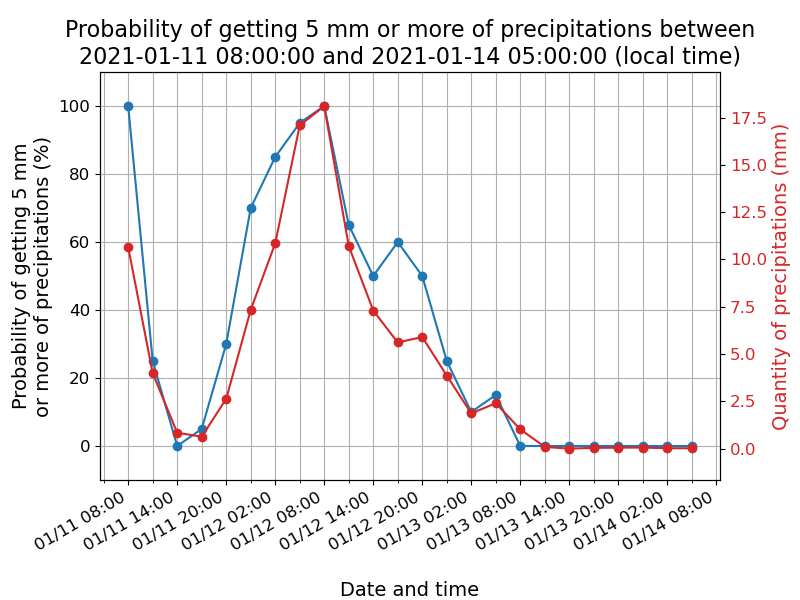

In [6]:
# Remove the magic command to use out of Jupyter Notebook
%matplotlib notebook


# Function to adjust the alignment of two y axis
def align_yaxis(ax, ax2):
    y_lims = numpy.array([ax.get_ylim() for ax in [ax, ax2]])

    # Normalize both y axis
    y_magnitudes = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_magnitudes

    # Find combined range
    y_new_lims_normalized = numpy.array([numpy.min(y_lims_normalized), 
                                         numpy.max(y_lims_normalized)])

    # Denormalize combined range to get new axis
    new_lim1, new_lim2 = y_new_lims_normalized * y_magnitudes
    ax2.set_ylim(new_lim2)

    
# Function to create the plot
def fig(x, y, title, xlabel, ylabel, ylim, color = 'black', y2 = '', y2label = ''):
    # Plot and text size parameters
    params = {'legend.fontsize': '14',
              'figure.figsize': (8, 6),
              'axes.labelsize': '14',
              'axes.titlesize': '16',
              'xtick.labelsize': '12',
              'ytick.labelsize': '12'}
    plt.rcParams.update(params)

    # Plot creation and plot styling
    fig, ax = plt.subplots()
    ax.plot(x, y, marker='o')

    # Titles
    plt.title(title)
    plt.xlabel(xlabel)
    ax.set_ylabel(ylabel, color=color)

    # Y axis range
    ax.set_ylim(ylim)
    ax.tick_params(axis='y', labelcolor=color)
    
    # Grid
    plt.grid(True, which='both')
    
    # Add a second dataset
    if y2 is not None:
        ax2 = plt.twinx()
        ax2.plot(x, y2, marker='o', color='tab:red')
        # Second y axis title
        ax2.set_ylabel(y2label, color='tab:red')
        # Range and ticks of second y axis
        ax2.set_ylim(0, (max(y2) * 1.1))
        ax2.tick_params(axis='y', labelcolor='tab:red')
        align_yaxis(ax, ax2)

    # Date format on x axis
    plt.gcf().autofmt_xdate()
    my_format = mdates.DateFormatter('%m/%d %H:%M')
    plt.gca().xaxis.set_major_formatter(my_format)

    # Graduation of x axis depending on the number of values plotted
    # Variable containing the hours for which there will be ticks: 
    hour = []
    for timestep in x:
        hour.append(int(timestep.strftime('%#H')))

    # Frequency of ticks and labels on the x axis
    if len(hour) < 8:
        # More precise graduation if there is only a few values plotted
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=hour))
    elif len(hour) > 8 and len(hour) <25:
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=hour, interval=2))
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=hour))
    else:
        # Coarser graduation if there is a lot of values plotted
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=(0, 12)))
    
    return fig

# Add quantity of precipitations to the plot
# Verification of temporal parameters compatibility:
start_time1, end_time1, interval1 = time_parameters('REPS.DIAG.3_PRMM.ERMEAN')

if (start_time1 == start_time
        and end_time1 == end_time
        and interval1 == interval):
    # GetFeatureInfo request
    y2 = request(layer = 'REPS.DIAG.3_PRMM.ERMEAN')
    y2label = 'Quantity of precipitations (mm)'
else:
    y2 = None
    y2label = None

# Create the plot with the fig function and show the plot
fig(x = local_time,
    y = pixel_value,
    title = ('Probability of getting 5 mm or more of precipitations between' +
             f'\n{local_time[0]} and {local_time[-1]} (local time)'),
    xlabel = '\nDate and time',
    ylabel = 'Probability of getting 5 mm\nor more of precipitations (%)',
    ylim = (-10, 110),
    y2 = y2,
    y2label = y2label
    )

plt.show()

Once the probabilities are obtained, Arthur must calculate the profits made with umbrellas sales. As mentioned earlier, he knows that his kiosk sells 3 umbrellas in average when there is less than 30% chance that there will be a minimum of 5 mm of precipitations. The sales increase by 10 umbrellas per hour when the probability of getting 5 mm of precipitations is 30% and continue to increase linearly to reach 30 umbrellas per hour when the probability is 100%. The number of umbrellas sold per hour if the probability of getting 5 mm of precipitations is 30% or more can be calculated with the following equations:

$$ m = \frac{y_2 - y_1}{x_2 - x_1} = \frac{30 - 10}{100 - 30}$$

$$ n_{umbrella} = 10 + m * (probability - 30)$$

Knowing that each umbrella sale earn Arthur 10,00$, it is possible to calculate the profits that he is predicted to make in the next 3 days with the following code.

In [7]:
# Umbrellas sold per day in average when there is less than 30% 
# chance that there will be a minimum of 5 mm of precipitations
base = 3

# Profits per umbrella
umbrella_profit = 10.00

# Slope calculation data
# When the probability of precipitations is 30%...
x1 = 30
# ... 10 umbrellas are sold each hour
y1 = 10
# When the probability of precipitations is 100%...
x2 = 100
# ... 30 umbrellas are sold each hour
y2 = 30

# Slope calculation
slope = ((y2-y1)/(x2-x1))

# Open hours
opening = '09:00:00'
opening = datetime.strptime(opening, '%H:%M:%S')
closing = '21:00:00'
closing = datetime.strptime(closing, '%H:%M:%S')

# Prediction times that are within the open hours
open_hours = []
for timestep in local_time:
    if (timestep.time() > opening.time() 
            and timestep.time() < closing.time()):
        open_hours.append(timestep)

# Number of umbrellas sold each day independently of meteorological conditions
opening_interval = (opening + timedelta(hours=interval)).time()
umbrella = []
for timestep in local_time:
    new_day = timestep.time() < opening_interval
    if (umbrella == [] or new_day) and timestep in open_hours:
        umbrella.append(base)      
    else:
        umbrella.append(0)

# Number of umbrellas sold and anticipated profits
# depending on precipitations probability
cumulative_profit = []
for index, probability in enumerate(pixel_value):
    # Equation to calculate the number of umbrellas sold per hour
    eq = y1 + round((probability - 30) * slope)
    # Equation to calculate the number of umbrellas sold between 2 predictions
    eq2 = eq * interval 
    if local_time[index] in open_hours and probability > 30:
        if index == 0:
            umbrella[index] = umbrella[index] + eq2
        else: 
            umbrella[index] = umbrella[index] + umbrella[index - 1] + eq2
    elif index != 0:
        umbrella[index] = umbrella[index] + umbrella[index-1]                            
    cumulative_profit.append(umbrella[index] * umbrella_profit)        

Results can be represented with a plot using the ``fig`` function created earlier.

<IPython.core.display.Javascript object>


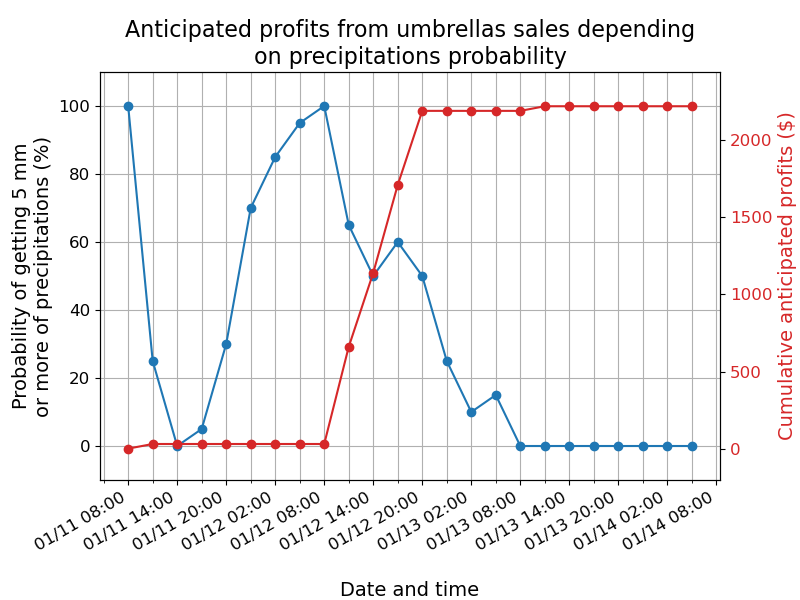

In [8]:
# Create and show plot
fig(x=local_time,
    y=pixel_value,
    title=('Anticipated profits from umbrellas sales ' +
             'depending\non precipitations probability'),
    xlabel='\nDate and time',
    ylabel='Probability of getting 5 mm\nor more of precipitations (%)',
    ylim=(-10, 110),
    y2=cumulative_profit,
    y2label='Cumulative anticipated profits ($)'
    )

plt.show()

Cumulative anticipated profits can also be show in a data table that can be exported in CSV format if desired.

In [9]:
# Probability of precipitations and cumulative
# profits only within open hours
probability = []
profit = []
for index, timestep in enumerate(local_time):
    if timestep in open_hours:
        probability.append(pixel_value[index])
        profit.append(cumulative_profit[index])

# Create table
profit_df = pandas.DataFrame({'Local date and time':  open_hours,
                              'Probability (%)': probability,
                              'Anticipated cumulative profits ($)': profit
                              })

# Show table
print('Anticipated profits from umbrellas sales ' +
      'depending on precipitations probability')
print(tabulate(profit_df,
               headers='keys',
               tablefmt='pretty',
               showindex=False))

# Save in CSV format (remove # from the following lines)
# profit_df.to_csv('profit.csv',
#                 sep=';',
#                 index=False,
#                 encoding='utf-8-sig')


Anticipated profits from umbrellas sales depending on precipitations probability
+---------------------+-----------------+------------------------------------+
| Local date and time | Probability (%) | Anticipated cumulative profits ($) |
+---------------------+-----------------+------------------------------------+
| 2021-01-11 11:00:00 |      25.0       |                30.0                |
| 2021-01-11 14:00:00 |       0.0       |                30.0                |
| 2021-01-11 17:00:00 |       5.0       |                30.0                |
| 2021-01-11 20:00:00 |      30.0       |                30.0                |
| 2021-01-12 11:00:00 |      65.0       |               660.0                |
| 2021-01-12 14:00:00 |      50.0       |               1140.0               |
| 2021-01-12 17:00:00 |      60.0       |               1710.0               |
| 2021-01-12 20:00:00 |      50.0       |               2190.0               |
| 2021-01-13 11:00:00 |       0.0       |         

## Conclusion

Using this tool, Arthur will have an insight of the profits he could make with umbrellas sales in the next days. After reading this use case exemple, you should be able to use Python programming to access and query a WMS service, create temporal queries and show the results using plots and data tables. You can adapt this exemple to fit your needs by changing the request parameters and the data processing steps.